In [9]:
#导入必要的模块
import numpy as np
import torch
#导入 PyTorch内置的mnist数据集
from torchvision.datasets import mnist
#导入预处理模块
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
#导入nn及优化器
import torch.nn.functional as F
import torch.optim as optim
from torch import nn

# 定义一些超参数
train_batch_size = 64
test_batch_size = 128
learning_rate = 0.01
num_epoches = 20
lr = 0.01
momentum = 0.9

# 定义预处理函数，这些预处理依次放在Compose函数中
# Normalize([0.5],[0.5]对张量进行归一化，这里两个0.5分别表示对张量进行归一化的全局平均值和方差。因图像使
#灰色的只有一个通道，需要有多个数字，如3个通道，应该是Normalize([m1,m2,m3],[n1,n2,n3]))
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5],[0.5])])
#下载数据，并对数据进行预处理
train_dataset = mnist.MNIST('./data',train=True, transform=transform, download=True)
test_dataset = mnist.MNIST('./data', train=False, transform=transform)
# dataloader是一个可迭代对象，可以使用迭代器一样使用
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

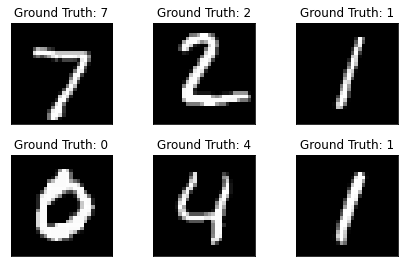

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

In [11]:
class Net(nn.Module):
    """
    使用sequential构建网络，Sequential()函数的功能是将网络的层组合到一起
    """
    def __init__(self, int_dim, n_hidden_1, n_hidden_2, out_dim):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(int_dim, n_hidden_1), nn.BatchNorm1d(n_hidden_1))
        self.layer2 = nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2), nn.BatchNorm1d(n_hidden_2))
        self.layer3 = nn.Sequential(nn.Linear(n_hidden_2,out_dim))
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [12]:
# 检测是否有可用的GPU,有则使用，否则使用CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#实例化网络
model = Net(28 * 28, 300, 100, 10)
model.to(device)

#定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [13]:

# 开始训练
losses = []
acces = []
eval_losses = []
eval_acces = []
for epoch in range(num_epoches):
    train_loss = 0
    train_acc = 0
    model.train()
    #动态修改参数学习率
    if epoch%5==0:
        optimizer.param_groups[0]['lr']*=0.9
    for img, label in train_loader:
        img=img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1)
        #前向传播
        out = model(img)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.item()
        # 计算分类的准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]
        train_acc += acc
        
    losses.append(train_loss / len(train_loader))
    acces.append(train_acc / len(train_loader))
    # 在测试集上检验效果
    eval_loss = 0
    eval_acc = 0
    # 将模型改为预测模式
    model.eval()
    for img, label in test_loader:
        img=img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1)
        out = model(img)
        loss = criterion(out, label)
        #记录误差
        eval_loss += loss.item()
        # 记录准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]
        eval_acc += acc
    eval_losses.append(eval_loss / len(test_loader))
    eval_acces.append(eval_acc / len(test_loader))
    print('epoch:{}, Train loss:{:.4f}, Train acc:{:.4f}, Test loss:{:.4f}, Test Acc:{:.4f}'
         .format(epoch, train_loss / len(train_loader), train_acc / len(train_loader), eval_loss / len(test_loader), eval_acc / len(test_loader)))

epoch:0, Train loss:0.2232, Train acc:0.9373, Test loss:0.0919, Test Acc:0.9708
epoch:1, Train loss:0.0870, Train acc:0.9734, Test loss:0.0762, Test Acc:0.9763
epoch:2, Train loss:0.0575, Train acc:0.9827, Test loss:0.0689, Test Acc:0.9784
epoch:3, Train loss:0.0443, Train acc:0.9862, Test loss:0.0605, Test Acc:0.9813
epoch:4, Train loss:0.0339, Train acc:0.9894, Test loss:0.0641, Test Acc:0.9790
epoch:5, Train loss:0.0263, Train acc:0.9922, Test loss:0.0578, Test Acc:0.9825
epoch:6, Train loss:0.0193, Train acc:0.9944, Test loss:0.0578, Test Acc:0.9821
epoch:7, Train loss:0.0174, Train acc:0.9951, Test loss:0.0576, Test Acc:0.9815
epoch:8, Train loss:0.0134, Train acc:0.9963, Test loss:0.0614, Test Acc:0.9814
epoch:9, Train loss:0.0112, Train acc:0.9970, Test loss:0.0573, Test Acc:0.9821
epoch:10, Train loss:0.0092, Train acc:0.9977, Test loss:0.0545, Test Acc:0.9840
epoch:11, Train loss:0.0075, Train acc:0.9980, Test loss:0.0571, Test Acc:0.9835
epoch:12, Train loss:0.0069, Train acc

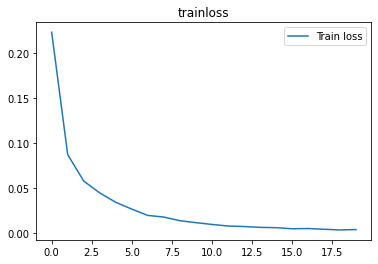

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('trainloss')
plt.plot(np.arange(len(losses)), losses)
plt.legend(['Train loss'],loc='upper right')